# 🧠 Práctica final NLP

## 📊 Análisis de Sentimiento - Reporte de métricas y conclusiones

### 🛒 Dataset: Reviews de Amazon

Este dataset contiene reseñas de productos de Amazon clasificadas por categorías, en este caso, **Deportes y actividades al aire libre**.  
Cada reseña incluye una calificación representada por un **número de estrellas ⭐**.


# 1. Cargar el dataset proprocesado, modelo y vectorizador

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import spacy
import json
from collections import Counter
import os

In [ ]:
nlp = spacy.load("en_core_web_sm")

# Cargar el dataset completo preprocesado
reviews_df = pd.read_csv('/content/preprocessed_dataset.csv')
print(f"Dataset cargado. Dimensiones: {reviews_df.shape}")

# Cargar el mejor modelo y vectorizador
print("\nCargando el mejor modelo y vectorizador...")
with open('/content/best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

with open('/content/best_vectorizer.pkl', 'rb') as f:
    best_vectorizer = pickle.load(f)

# Cargar los resultados de entrenamiento
with open('/content/training_results.json', 'r') as f:
    training_results = json.load(f)

best_model_name = training_results['mejor_modelo']
print(f"Modelo cargado: {best_model_name}")

Dataset cargado. Dimensiones: (10000, 12)

Cargando el mejor modelo y vectorizador...
Modelo cargado: Regresión Logística con TF-IDF


In [ ]:
# Obtener información sobre los datos de prueba
# Preparar datos de prueba
binary_df = reviews_df[reviews_df['sentiment'] != 'neutral'].copy()
binary_df['sentiment_binary'] = binary_df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Verificar balance de clases en todo el dataset
class_balance = binary_df['sentiment_binary'].value_counts(normalize=True)
print("\nBalance de clases en todo el dataset:")
print(class_balance)


Balance de clases en todo el dataset:
sentiment_binary
1    0.5
0    0.5
Name: proportion, dtype: float64


# 2. Dividir datos

In [ ]:
# Dividir datos de la misma manera que en el entrenamiento
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    binary_df['processed_text_advanced'],
    binary_df['sentiment_binary'],
    test_size=0.2,
    random_state=42,
    stratify=binary_df['sentiment_binary']
)

# Vectorizar conjunto de prueba
X_test_vec = best_vectorizer.transform(X_test)

# Realizar predicciones con el mejor modelo
y_pred = best_model.predict(X_test_vec)
if hasattr(best_model, 'predict_proba'):
    y_pred_proba = best_model.predict_proba(X_test_vec)[:, 1]
else:
    y_pred_proba = None

# 3. Matriz de confusión del modelo


Análisis detallado del modelo en el conjunto de prueba:
Matriz de Confusión:
[[886 114]
 [133 867]]


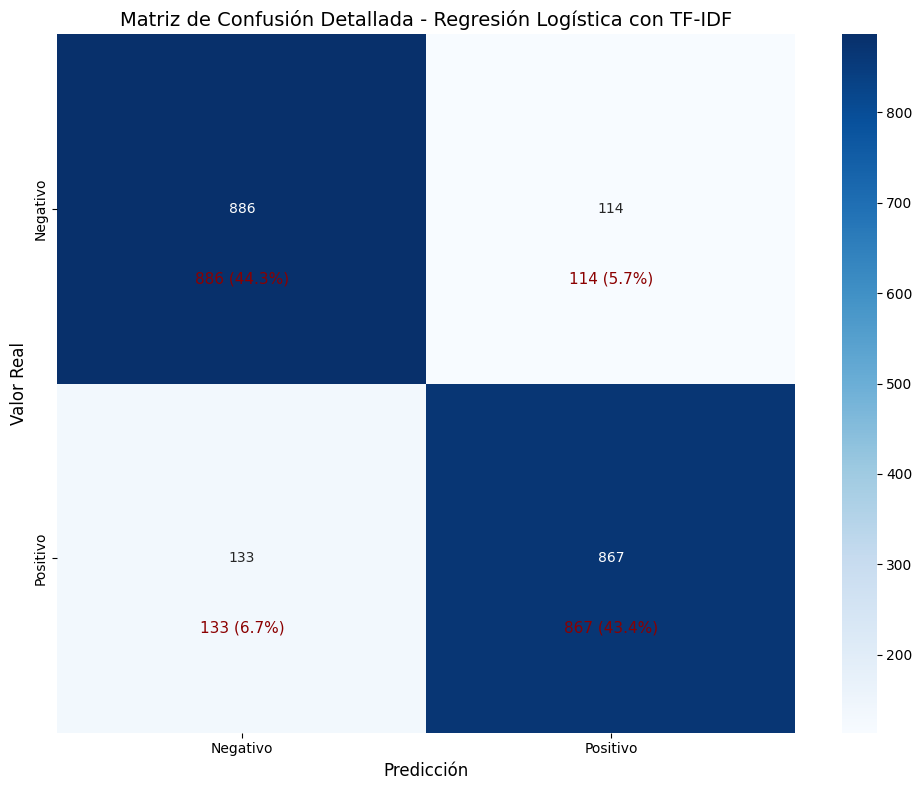

In [ ]:
print("\nAnálisis detallado del modelo en el conjunto de prueba:")
print("="*50)

# Matriz de Confusión Detallada
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusión:")
print(conf_matrix)

# Visualizar matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativo', 'Positivo'],
            yticklabels=['Negativo', 'Positivo'])
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor Real', fontsize=12)
plt.title(f'Matriz de Confusión Detallada - {best_model_name}', fontsize=14)

# Añadir valores y porcentajes
total = sum(sum(conf_matrix))
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j + 0.5, i + 0.7,
                f'{conf_matrix[i][j]} ({conf_matrix[i][j]/total*100:.1f}%)',
                ha='center', va='center', fontsize=11, color='darkred')

plt.tight_layout()
plt.show()

# 4. Métricas


Métricas por Clase:
  Métrica    Negativo    Positivo
Precisión    0.869480    0.883792
   Recall    0.886000    0.867000
 F1-Score    0.877662    0.875315
  Soporte 1000.000000 1000.000000


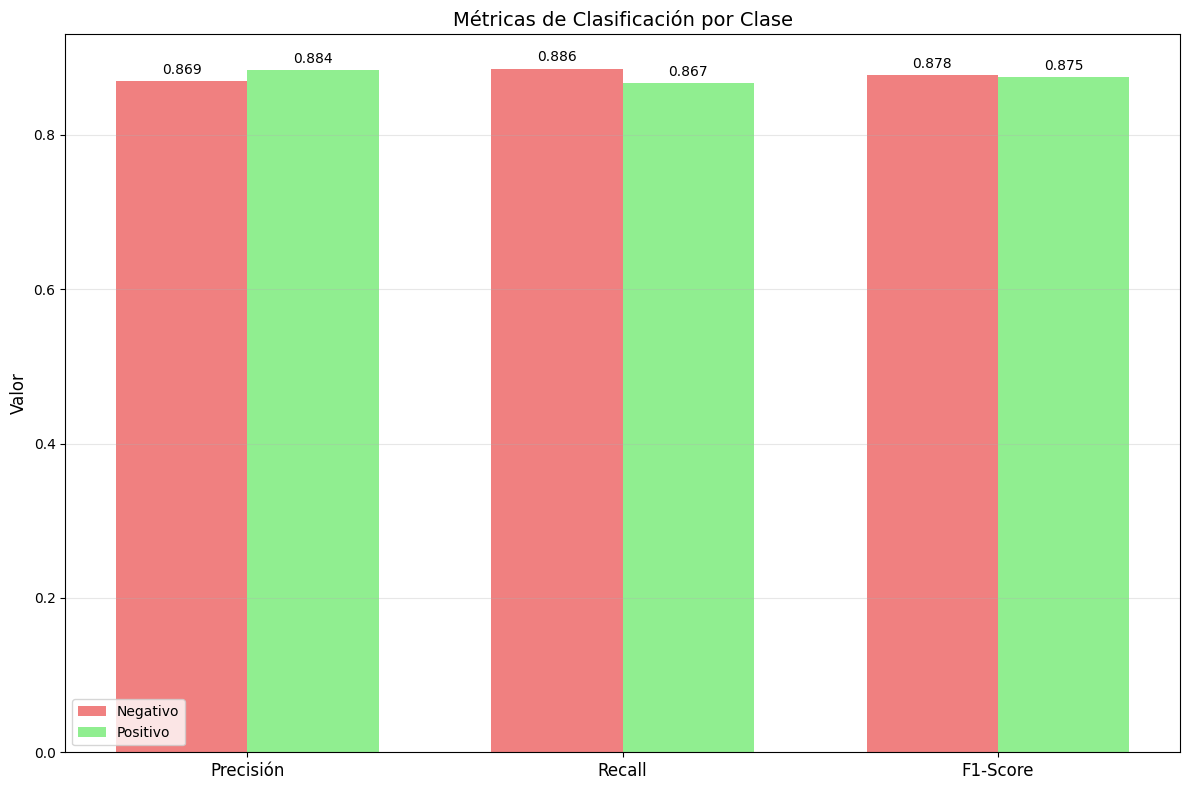

In [ ]:
# Métricas Detalladas por Clase
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

metrics_data = {
    'Métrica': ['Precisión', 'Recall', 'F1-Score', 'Soporte'],
    'Negativo': [precision[0], recall[0], f1[0], support[0]],
    'Positivo': [precision[1], recall[1], f1[1], support[1]]
}

metrics_df = pd.DataFrame(metrics_data)
print("\nMétricas por Clase:")
print(metrics_df.to_string(index=False))

# Visualizar métricas
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(metrics_data['Métrica'][:3]))  # Solo para precision, recall, f1
width = 0.35

bars1 = ax.bar(x - width/2, metrics_df['Negativo'][:3], width, label='Negativo', color='lightcoral')
bars2 = ax.bar(x + width/2, metrics_df['Positivo'][:3], width, label='Positivo', color='lightgreen')

ax.set_ylabel('Valor', fontsize=12)
ax.set_title('Métricas de Clasificación por Clase', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(metrics_data['Métrica'][:3], fontsize=12)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Agregar valores sobre las barras
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

autolabel(bars1)
autolabel(bars2)

plt.tight_layout()
plt.show()

# 5. Análisis de Errores

In [ ]:
# Guardar predicciones junto con textos originales para análisis
test_results = pd.DataFrame({
    'review_text': X_test.values,
    'true_sentiment': y_test.values,
    'predicted_sentiment': y_pred
})

# Identificar falsos positivos y falsos negativos
false_positives = test_results[(test_results['true_sentiment'] == 0) &
                              (test_results['predicted_sentiment'] == 1)]
false_negatives = test_results[(test_results['true_sentiment'] == 1) &
                               (test_results['predicted_sentiment'] == 0)]

print(f"\nAnálisis de Errores:")
print(f"Total de Falsos Positivos: {len(false_positives)} ({len(false_positives)/len(test_results)*100:.1f}%)")
print(f"Total de Falsos Negativos: {len(false_negatives)} ({len(false_negatives)/len(test_results)*100:.1f}%)")



Análisis de Errores:
Total de Falsos Positivos: 114 (5.7%)
Total de Falsos Negativos: 133 (6.7%)


In [ ]:
# Mostrar ejemplos de errores
print("\nEjemplos de Falsos Positivos (clasificados como positivos pero son negativos):")
for i, row in false_positives.head(3).iterrows():
    print(f"  - '{row['review_text'][:100]}...'")

print("\nEjemplos de Falsos Negativos (clasificados como negativos pero son positivos):")
for i, row in false_negatives.head(3).iterrows():
    print(f"  - '{row['review_text'][:100]}...'")

# Calcular patrones comunes en errores
def get_common_words(texts):
    all_words = []
    for text in texts:
        if isinstance(text, str):
            words = text.split()
            all_words.extend(words)
    return Counter(all_words).most_common(10)

print("\nPalabras más comunes en Falsos Positivos:")
fp_words = get_common_words(false_positives['review_text'])
for word, count in fp_words:
    print(f"  - '{word}': {count}")

print("\nPalabras más comunes en Falsos Negativos:")
fn_words = get_common_words(false_negatives['review_text'])
for word, count in fn_words:
    print(f"  - '{word}': {count}")


Ejemplos de Falsos Positivos (clasificados como positivos pero son negativos):
  - 'knife kid know shrade sell orderd half width weight way use case nice recommend read write up...'
  - 'look advertisement impression get pound jar media come red stuff purchasecorn medium brass polish cl...'
  - 'good play lot mean lot beer pong plan bounce ball impossible play ping pong ball bounce smooth plast...'

Ejemplos de Falsos Negativos (clasificados como negativos pero son positivos):
  - 'thank need impossible aquire producti think use remington gauge shotgunkeepe factory spec order come...'
  - 'sevenyearold time customize colorful neon animal print duct tape easy identification local brooklyn ...'
  - 'powerful blow kind air product minute cut star noisy maybe powerful mode low noise embarrassing air ...'

Palabras más comunes en Falsos Positivos:
  - 'knife': 54
  - 'work': 51
  - 'use': 39
  - 'good': 34
  - 'buy': 34
  - 'fit': 25
  - 'blade': 25
  - 'time': 25
  - 'great': 25
  - 'year

# 6.Análisis de características (palabras) importantes


Palabras más importantes para sentimiento POSITIVO:
  - 'great': 5.9798
  - 'easy': 5.4002
  - 'perfect': 4.1478
  - 'clean': 3.9190
  - 'love': 3.8509
  - 'good': 3.0381
  - 'excellent': 2.9177
  - 'job': 2.8247
  - 'speedloader': 2.6752
  - 'nice': 2.6218
  - 'perfectly': 2.5945
  - 'highly recommend': 2.5692
  - 'year': 2.5489
  - 'shell': 2.5288
  - 'soap': 2.4563
  - 'highly': 2.3983
  - 'need': 2.2105
  - 'loader': 2.1063
  - 'cleaning': 2.1006
  - 'price': 2.0537

Palabras más importantes para sentimiento NEGATIVO:
  - 'return': -5.3532
  - 'useless': -3.3274
  - 'poor': -3.2421
  - 'bad': -3.1692
  - 'send': -3.1478
  - 'break': -2.8687
  - 'waste': -2.8475
  - 'cheap': -2.7602
  - 'disappointed': -2.6256
  - 'bike': -2.4743
  - 'try': -2.4317
  - 'tube': -2.3126
  - 'junk': -2.2498
  - 'sight': -2.1959
  - 'flimsy': -2.1828
  - 'maybe': -2.0638
  - 'fall': -1.9931
  - 'way': -1.9611
  - 'pay': -1.8849
  - 'fail': -1.8413


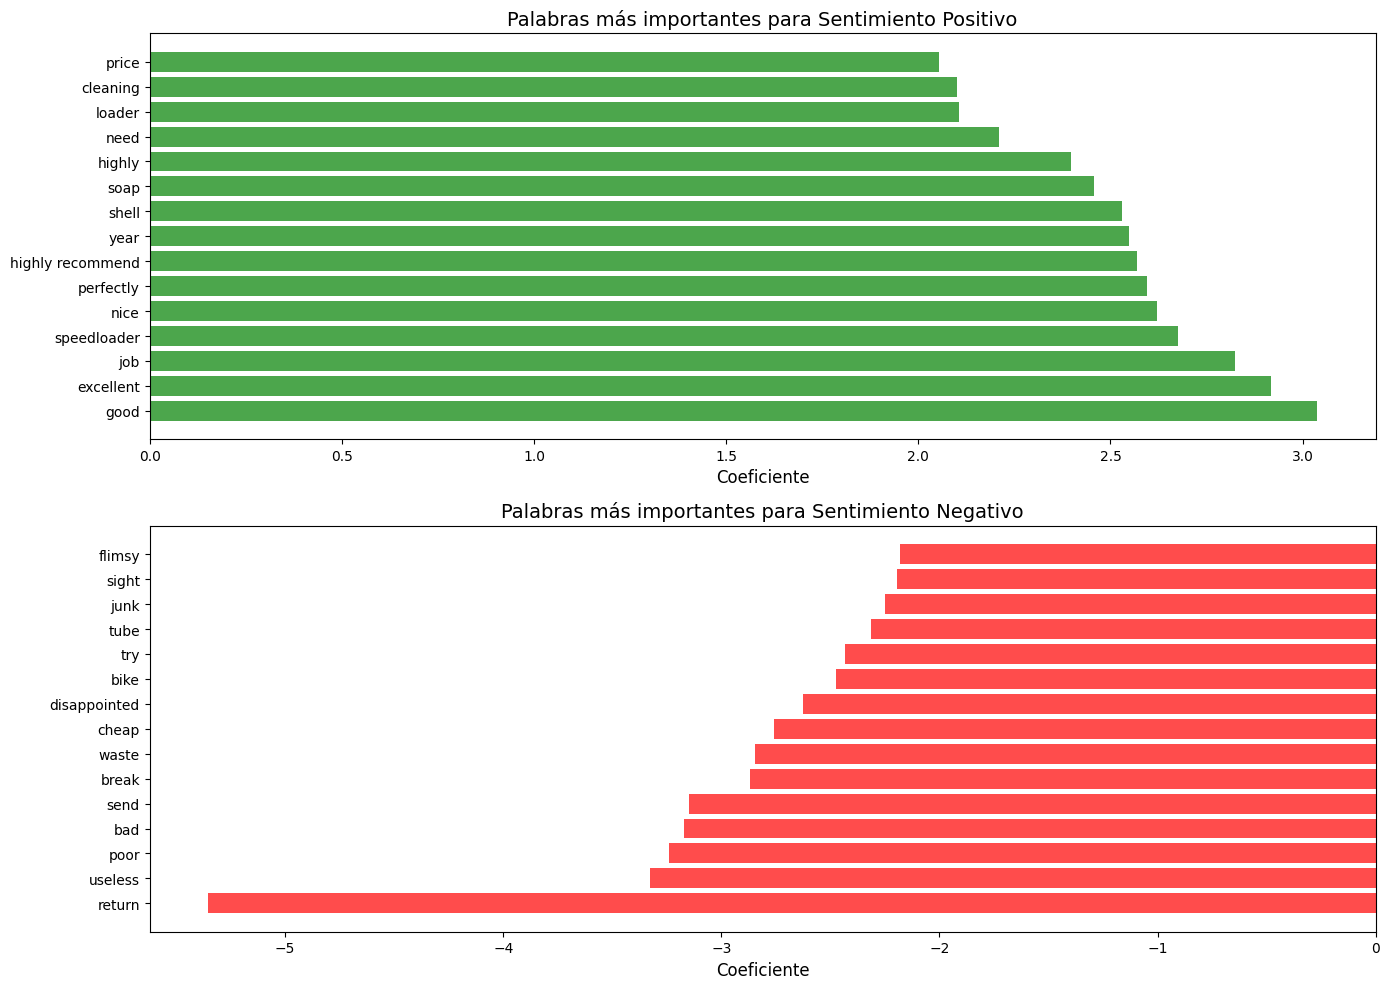

In [ ]:
if hasattr(best_model, 'coef_'):
    feature_names = best_vectorizer.get_feature_names_out()
    coefficients = best_model.coef_[0]

    # Top palabras para cada clase
    top_positive_indices = coefficients.argsort()[-20:]
    top_negative_indices = coefficients.argsort()[:20]

    top_positive_features = [(feature_names[i], coefficients[i]) for i in top_positive_indices]
    top_negative_features = [(feature_names[i], coefficients[i]) for i in top_negative_indices]

    print("\nPalabras más importantes para sentimiento POSITIVO:")
    for feature, coef in reversed(top_positive_features):
        print(f"  - '{feature}': {coef:.4f}")

    print("\nPalabras más importantes para sentimiento NEGATIVO:")
    for feature, coef in top_negative_features:
        print(f"  - '{feature}': {coef:.4f}")

    # Visualizar palabras importantes
    plt.figure(figsize=(14, 10))

    # Palabras positivas
    plt.subplot(2, 1, 1)
    features = [f[0] for f in reversed(top_positive_features[:15])]
    importances = [f[1] for f in reversed(top_positive_features[:15])]
    plt.barh(features, importances, color='green', alpha=0.7)
    plt.title('Palabras más importantes para Sentimiento Positivo', fontsize=14)
    plt.xlabel('Coeficiente', fontsize=12)

    # Palabras negativas
    plt.subplot(2, 1, 2)
    features = [f[0] for f in top_negative_features[:15]]
    importances = [f[1] for f in top_negative_features[:15]]
    plt.barh(features, importances, color='red', alpha=0.7)
    plt.title('Palabras más importantes para Sentimiento Negativo', fontsize=14)
    plt.xlabel('Coeficiente', fontsize=12)

    plt.tight_layout()
    plt.show()

# 7. Probar el modelo con nuevos ejemplos

In [ ]:
print("\nPrueba con nuevos ejemplos:")
print("="*50)

new_examples = [
    # Claramente positivos
    "This product is fantastic. I love everything about it!",
    "Amazing customer service and quick shipping! Will definitely buy again.",
    "Exceeded all my expectations. Best purchase I've made this year.",
    "Perfect for my needs. Very durable and well-made.",
    "Great value for the money. Highly recommended!",
    "The quality is outstanding. Five stars without hesitation.",
    "Works exactly as described. Very satisfied with this purchase.",

    # Claramente negativos
    "Terrible quality, broke after one day. Would not recommend.",
    "Waste of money. Doesn't work at all as advertised.",
    "Awful customer service. Still waiting for a refund after 3 weeks.",
    "The product arrived damaged and customer support was unhelpful.",
    "Low quality materials. Already falling apart after minimal use.",
    "Complete disappointment. Save your money and look elsewhere.",
    "Instructions were unclear and the product is difficult to use.",

    # Mixtos/Ambiguos
    "It's ok but not the best I've used. A bit expensive for what it offers.",
    "Good product overall, but shipping was slow.",
    "Nice features but the build quality could be better.",
    "Works fine for casual use, but serious athletes should look elsewhere.",
    "The product itself is decent, but the customer service is lacking.",
    "Has some good points, but also some significant flaws.",
    "Not terrible, but wouldn't buy again at this price point."
]

# Función para preprocesar y hacer predicción
def predict_sentiment(text):
    # Preprocesar igual que en el entrenamiento
    processed_text = text
    if hasattr(nlp, '__call__'):
        doc = nlp(text.lower())
        processed_tokens = []
        for token in doc:
            if not token.is_stop and not token.is_punct and not token.is_space and len(token.text) > 2:
                processed_tokens.append(token.lemma_)
        processed_text = ' '.join(processed_tokens)

    # Vectorizar
    vectorized = best_vectorizer.transform([processed_text])

    # Predecir
    prediction = best_model.predict(vectorized)[0]
    if hasattr(best_model, 'predict_proba'):
        probability = best_model.predict_proba(vectorized)[0][prediction]
    else:
        probability = None

    return {
        'sentiment': 'Positivo' if prediction == 1 else 'Negativo',
        'probability': probability
    }

for i, example in enumerate(new_examples):
    result = predict_sentiment(example)
    print(f"Ejemplo {i+1}: \"{example}\"")
    print(f"Predicción: {result['sentiment']}")
    if result['probability'] is not None:
        print(f"Confianza: {result['probability']:.2f}")
    print("-"*50)


Prueba con nuevos ejemplos:
Ejemplo 1: "This product is fantastic. I love everything about it!"
Predicción: Positivo
Confianza: 0.93
--------------------------------------------------
Ejemplo 2: "Amazing customer service and quick shipping! Will definitely buy again."
Predicción: Positivo
Confianza: 0.59
--------------------------------------------------
Ejemplo 3: "Exceeded all my expectations. Best purchase I've made this year."
Predicción: Positivo
Confianza: 0.79
--------------------------------------------------
Ejemplo 4: "Perfect for my needs. Very durable and well-made."
Predicción: Positivo
Confianza: 0.98
--------------------------------------------------
Ejemplo 5: "Great value for the money. Highly recommended!"
Predicción: Positivo
Confianza: 0.96
--------------------------------------------------
Ejemplo 6: "The quality is outstanding. Five stars without hesitation."
Predicción: Positivo
Confianza: 0.54
--------------------------------------------------
Ejemplo 7: "Works

# 8. CONCLUSIONES FINALES

## Modelo Seleccionado
- **Regresión Logística con TF-IDF**
- **Accuracy:** 87.65%  
- **F1-Score Positivo:** 87.53% | **F1-Score Negativo:** 87.77%  

## Justificación de TF-IDF
Opté por **TF-IDF** en lugar de bag-of-words porque:
- **Compatibilidad con regresión logística**: Facilita la interpretación de coeficientes.
- **Mejor desempeño**: **1.3% más de accuracy** frente a bag-of-words.

## Fortalezas
- Clasifica correctamente **867** reviews positivas (**86.7%**).
- Clasifica correctamente **886** reviews negativas (**88.6%**).
- Identifica **palabras clave relevantes**.

## Áreas de Mejora
- **Falsos positivos:** 11.4% | **Falsos negativos:** 13.3%.

**Conclusión:** La **Regresión Logística con TF-IDF** ha demostrado ser **efectiva y fiable**.
